In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

In [3]:
def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

In [4]:
def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c

In [5]:
#ref from class Constellation
def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    r"""
    Constellation(constellation_type, num_bits_per_symbol, initial_value=None, normalize=True, center=False, trainable=False, dtype=tf.complex64, **kwargs)

    Constellation that can be used by a (de)mapper.

    This class defines a constellation, i.e., a complex-valued vector of
    constellation points. A constellation can be trainable. The binary
    representation of the index of an element of this vector corresponds
    to the bit label of the constellation point. This implicit bit
    labeling is used by the ``Mapper`` and ``Demapper`` classes.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", the constellation points are randomly initialized
        if no ``initial_value`` is provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    initial_value : :math:`[2^\text{num_bits_per_symbol}]`, NumPy array or Tensor
        Initial values of the constellation points. If ``normalize`` or
        ``center`` are `True`, the initial constellation might be changed.

    normalize : bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    center : bool
        If `True`, the constellation is ensured to have zero mean.
        Defaults to `False`.

    trainable : bool
        If `True`, the constellation points are trainable variables.
        Defaults to `False`.

    dtype : [tf.complex64, tf.complex128], tf.DType
        The dtype of the constellation.

    Output
    ------
    : :math:`[2^\text{num_bits_per_symbol}]`, ``dtype``
        The constellation.

    Note
    ----
    One can create a trainable PAM/QAM constellation. This is
    equivalent to creating a custom trainable constellation which is
    initialized with PAM/QAM constellation points.
    """
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    if constellation_type=="pam":
        assert num_bits_per_symbol>0,\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = pam(num_bits_per_symbol, normalize=normalize)
    return points

In [8]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [11]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
#constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape


(4,)

In [12]:
points

array([ 0.70710677+0.70710677j,  0.70710677-0.70710677j,
       -0.70710677+0.70710677j, -0.70710677-0.70710677j], dtype=complex64)

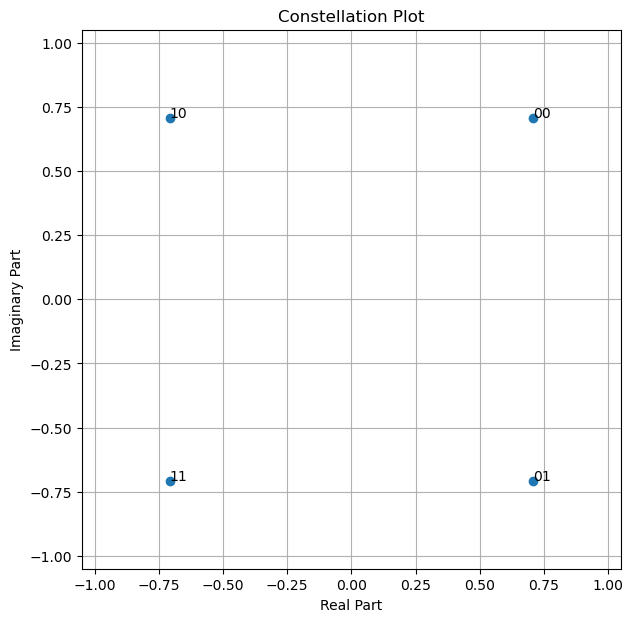

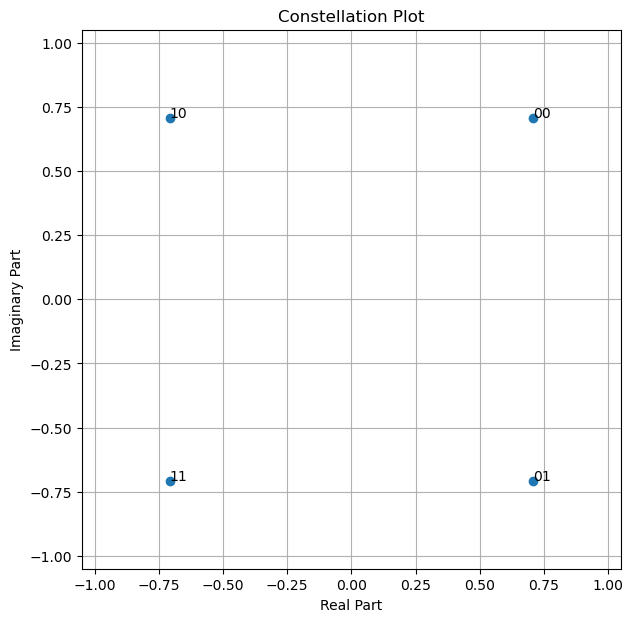

In [13]:
show(points, NUM_BITS_PER_SYMBOL)

We then need to setup a mapper to map bits into constellation points. The mapper takes as parameter the constellation.

We also need to setup a corresponding demapper to compute log-likelihood ratios (LLRs) from received noisy samples.

In [14]:
def BinarySource(shape):
    """BinarySource(dtype=tf.float32, seed=None, **kwargs)

    Layer generating random binary tensors.

    Parameters
    ----------
    dtype : tf.DType
        Defines the output datatype of the layer.
        Defaults to `tf.float32`.

    seed : int or None
        Set the seed for the random generator used to generate the bits.
        Set to `None` for random initialization of the RNG.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor filled with random binary values.
    """
    #tf.cast(tf.random.uniform(inputs, 0, 2, tf.int32), dtype=super().dtype)
    return np.random.randint(2, size=shape)
    #https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html#numpy.random.randint

In [15]:
BATCH_SIZE = 64 # How many examples are processed in parallel
shape = ([BATCH_SIZE,
                      1024])# Blocklength

bits = BinarySource(shape)

In [18]:
print("Shape of bits: ", bits.shape)

Shape of bits:  (64, 1024)


In [17]:
bits

array([[1, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [19]:
def mapper(inputs, num_bits_per_symbol):
    # Reshape inputs to the desired format
    new_shape = [-1] + inputs.shape[1:-1].as_list() + \
        [int(inputs.shape[-1] / num_bits_per_symbol),
        num_bits_per_symbol]
    return np.reshape(inputs, new_shape)

In [28]:
inputs = bits
num_bits_per_symbol=2
[-1] + [1] + [int(inputs.shape[-1] / num_bits_per_symbol),
        num_bits_per_symbol]

[-1, 1, 512, 2]

In [20]:
x = mapper(bits, NUM_BITS_PER_SYMBOL)
print("Shape of x: ", x.shape)

AttributeError: 'tuple' object has no attribute 'as_list'